# Uses Autoencoder with batch normalization

In [4]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from models import BatchNormAutoencoder

import normal dataset

In [5]:
import pandas as pd

train_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/train_set_full.csv"
)
train_df = pd.read_csv(train_set_path)
train_df = train_df.sample(frac=0.1, random_state=42).reset_index(drop=True)
print(train_df.shape)
train_df.head(3)

(6734, 122)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,5.833486e-07,2.572642e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,2.702969e-07,2.616156e-06,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.579751e-07,2.145141e-07,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


splitting dataset

In [6]:
from sklearn.model_selection import train_test_split

X_train_full = train_df.values
X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42)
X_train = X_train.values
X_val = X_val.values
print(X_train.shape, X_val.shape, X_train_full.shape)

(5387, 122) (1347, 122) (6734, 122)


In [7]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_val_tensor = torch.FloatTensor(X_val)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor)
val_dataset = TensorDataset(X_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

input_dim = X_train.shape[1]
hidden_dims_gradual = [64, 24]  # latent_dim = 16
hidden_dims_gradual = [96, 63]  # latent_dim = 32
hidden_dims_deep = [100, 80, 60]  # latent_dim = 40
hidden_dims_conservative = [96, 64]  # latent_dim = 55
latent_dim = 55

autoencoder = BatchNormAutoencoder(
    input_dim=input_dim,
    hidden_dims=hidden_dims_conservative,
    latent_dim=latent_dim,
    activation_type="LeakyReLU",
    output_activation_type="Sigmoid",  # Since data is normalized to [0,1]
)

autoencoder = autoencoder.to(device)

Using device: cpu
Training autoencoder...
Epoch 1/10, Train Loss: 0.2349715451, Val Loss: 0.2230593129
✅ Model saved with val_loss: 0.2230593129
Epoch 2/10, Train Loss: 0.1958828537, Val Loss: 0.1763752143
✅ Model saved with val_loss: 0.1763752143
Epoch 3/10, Train Loss: 0.1591024926, Val Loss: 0.1402661855
✅ Model saved with val_loss: 0.1402661855
Epoch 4/10, Train Loss: 0.1269351885, Val Loss: 0.1125544045
✅ Model saved with val_loss: 0.1125544045
Epoch 5/10, Train Loss: 0.1015462508, Val Loss: 0.0908145742
✅ Model saved with val_loss: 0.0908145742


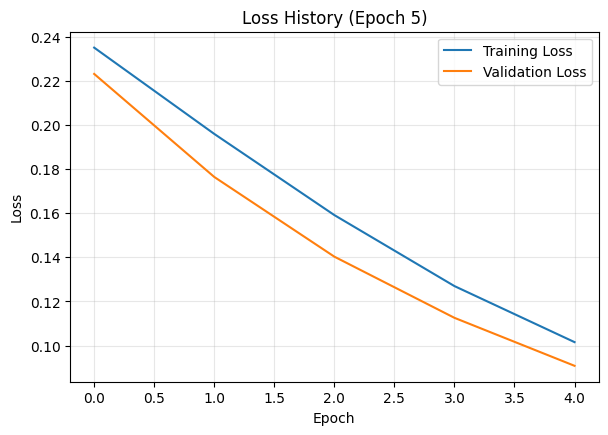

Epoch 6/10, Train Loss: 0.0819698305, Val Loss: 0.0718148378
✅ Model saved with val_loss: 0.0718148378
Epoch 7/10, Train Loss: 0.0668538468, Val Loss: 0.0602207800
✅ Model saved with val_loss: 0.0602207800
Epoch 8/10, Train Loss: 0.0551352055, Val Loss: 0.0500574999
✅ Model saved with val_loss: 0.0500574999
Epoch 9/10, Train Loss: 0.0465197050, Val Loss: 0.0425291044
✅ Model saved with val_loss: 0.0425291044
Epoch 10/10, Train Loss: 0.0397195275, Val Loss: 0.0366284973
✅ Model saved with val_loss: 0.0366284973


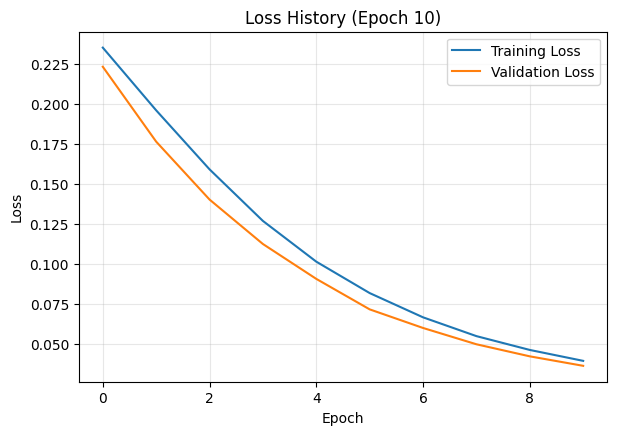

In [9]:
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim

epochs = 10
learning_rate = 0.0001
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)
criterion = nn.MSELoss()

best_model_path = "./best_autoencoder.pth"

print(f"Using device: {device}")
print("Training autoencoder...")


history = {"loss": [], "val_loss": []}
autoencoder.train()

best_val_loss = float('inf')
for epoch in range(epochs):
    total_loss = 0.0
    for batch in train_loader:
        batch_x = batch[0].to(device)

        # Forward pass
        outputs = autoencoder(batch_x)
        loss = criterion(outputs, batch_x)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print epoch statistics
    avg_loss = total_loss / len(train_loader)
    # print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.6f}")
    history["loss"].append(avg_loss)

    if val_loader is not None:
        autoencoder.eval()
        val_loss = 0.0

        with torch.no_grad():
            for val_batch in val_loader:
                val_inputs = val_batch[0].to(device)
                val_outputs = autoencoder(val_inputs)
                batch_val_loss = criterion(val_outputs, val_inputs).item()
                val_loss += batch_val_loss

        avg_val_loss = val_loss / len(val_loader)
        history["val_loss"].append(avg_val_loss)
        print(
            f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.10f}, Val Loss: {avg_val_loss:.10f}"
        )
        # Save model if validation loss improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': best_val_loss,
            }, best_model_path)
            print(f"✅ Model saved with val_loss: {best_val_loss:.10f}")
            autoencoder.train()  # Switch back to training mode after validation
    else:
        # If no validation set, save based on training loss
        if avg_loss < best_val_loss:
            best_val_loss = avg_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': best_val_loss,
            }, best_model_path)
            print(f"✅ Model saved with train_loss: {best_val_loss:.10f}")
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.10f}")

    if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
        plt.figure(figsize=(15, 10))

        # Plot 1: Loss history
        plt.subplot(2, 2, 1)
        plt.plot(history["loss"], label="Training Loss")
        if "val_loss" in history and history["val_loss"]:
            plt.plot(history["val_loss"], label="Validation Loss")
        plt.title(f"Loss History (Epoch {epoch+1})")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        plt.close()

In [10]:
# Load best model
print("Training complete. Loading best model...")
checkpoint = torch.load(best_model_path)
autoencoder.load_state_dict(checkpoint['model_state_dict'])
best_epoch = checkpoint['epoch']
best_loss = checkpoint.get('val_loss', checkpoint.get('train_loss'))
print(f"Loaded model from epoch {best_epoch+1} with {'validation' if 'val_loss' in checkpoint else 'training'} loss: {best_loss:.4f}")
# Set model to evaluation mode
autoencoder.eval()

Training complete. Loading best model...
Loaded model from epoch 10 with validation loss: 0.0366


BatchNormAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=122, out_features=96, bias=True)
    (1): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=96, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=55, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=55, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=96, bias=True)
    (4): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=96, out_features=122, bias=True)
    (7): Sigmoid()
  )
)

import test

In [11]:
import torch.onnx

# Set model to evaluation mode
autoencoder.eval()

# Prepare a sample input tensor with the correct shape
dummy_input = torch.randn(1, input_dim, device=device)

# Export the model to ONNX format
onnx_path = "saved_models/autoencoder.onnx"
torch.onnx.export(
    autoencoder,                      # model being run
    dummy_input,                      # model input
    onnx_path,                        # where to save the model
    export_params=True,               # store trained parameters inside model file
    opset_version=12,                 # ONNX version
    do_constant_folding=True,         # optimize constant folding
    input_names=['input'],            # model's input names
    output_names=['output'],          # model's output names
    dynamic_axes={
        'input': {0: 'batch_size'},   # variable length axes
        'output': {0: 'batch_size'}
    }
)

print(f"Model exported to ONNX format: {onnx_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/autoencoder.onnx'

In [ ]:
test_set_path = (
    "/home/jbct/Projects/thesis/db-ocsvm/data/processed/NSL-KDD/test_set.csv"
)
test_df = pd.read_csv(test_set_path)
print(test_df.shape)
test_df.head()

(22543, 125)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_binary,attack_categorical,attack_class
0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,neptune,DoS
1,0.000047,9.408217e-06,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,normal,normal
2,0.000000,1.449313e-08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1,saint,Probe
3,0.000023,0.000000e+00,1.145093e-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,mscan,Probe
4,0.000000,1.934833e-07,1.108068e-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,normal,normal


In [ ]:
X_test = test_df.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_class"]

In [ ]:
from utils import evaluate_reconstruction_error

X_test = test_df.drop(
    columns=["attack_binary", "attack_categorical", "attack_class"]
).values
y_test = test_df["attack_binary"].values
y_test_class = test_df["attack_class"]

print(X_test.shape, y_test.shape)
print("Evaluating reconstruction error...")

results = evaluate_reconstruction_error(
    autoencoder, X_test, y_test, device, model_type="batch_norm_autoencoder"
)

(22543, 122) (22543,)
Evaluating reconstruction error...
Avg Reconstruction Error (Normal): 0.0042
Avg Reconstruction Error (Anomaly): 0.0370
Error Ratio (Anomaly/Normal): 8.80x


In [ ]:
# Extract features from normal training data for OCSVM
autoencoder.eval()
X_train_normal_tensor = torch.FloatTensor(X_train_full).to(device)
normal_features = []

# Extract in batches to prevent memory issues
normal_dataset = TensorDataset(
    X_train_normal_tensor, torch.zeros(len(X_train_normal_tensor))
)
normal_loader = DataLoader(normal_dataset, batch_size=128)

with torch.no_grad():
    for data, _ in normal_loader:
        encoded = autoencoder.encode(data)
        normal_features.append(encoded.cpu().numpy())

normal_features = np.vstack(normal_features)
print(normal_features.shape)

(6734, 55)


In [ ]:
# Extract features from test data
X_test_tensor = torch.FloatTensor(X_test).to(device)
test_features = []

test_dataset = TensorDataset(X_test_tensor, torch.zeros(len(X_test_tensor)))
test_loader = DataLoader(test_dataset, batch_size=128)

with torch.no_grad():
    for data, _ in test_loader:
        encoded = autoencoder.encode(data)
        test_features.append(encoded.cpu().numpy())

test_features = np.vstack(test_features)
print(test_features.shape)

(22543, 55)


In [ ]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.2, kernel="rbf", gamma="auto")
ocsvm.fit(normal_features)

OneClassSVM(gamma='auto', nu=0.2)

In [ ]:
# Predict on test data
y_pred = ocsvm.predict(test_features)

Confusion Matrix:


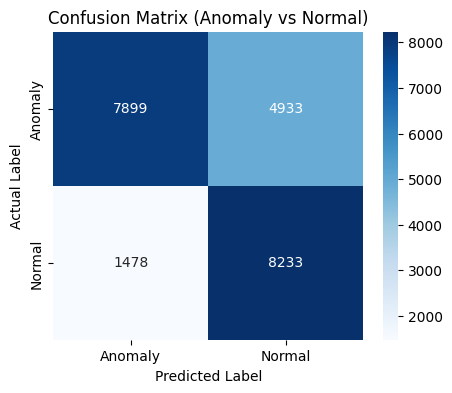

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=[-1, 1])

# Print the confusion matrix
print("Confusion Matrix:")


def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title(title)
    plt.show()


plot_confusion_matrix(cm, ["Anomaly", "Normal"], "Confusion Matrix (Anomaly vs Normal)")

In [ ]:
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Anomaly", "Normal"]))

precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)
acc = accuracy_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {acc}")

Classification Report:
              precision    recall  f1-score   support

     Anomaly       0.84      0.62      0.71     12832
      Normal       0.63      0.85      0.72      9711

    accuracy                           0.72     22543
   macro avg       0.73      0.73      0.72     22543
weighted avg       0.75      0.72      0.71     22543

Precision: 0.8423802922043298
Recall: 0.6155704488778054
F1 Score: 0.7113332432797514
Accuracy: 0.7156101672359491


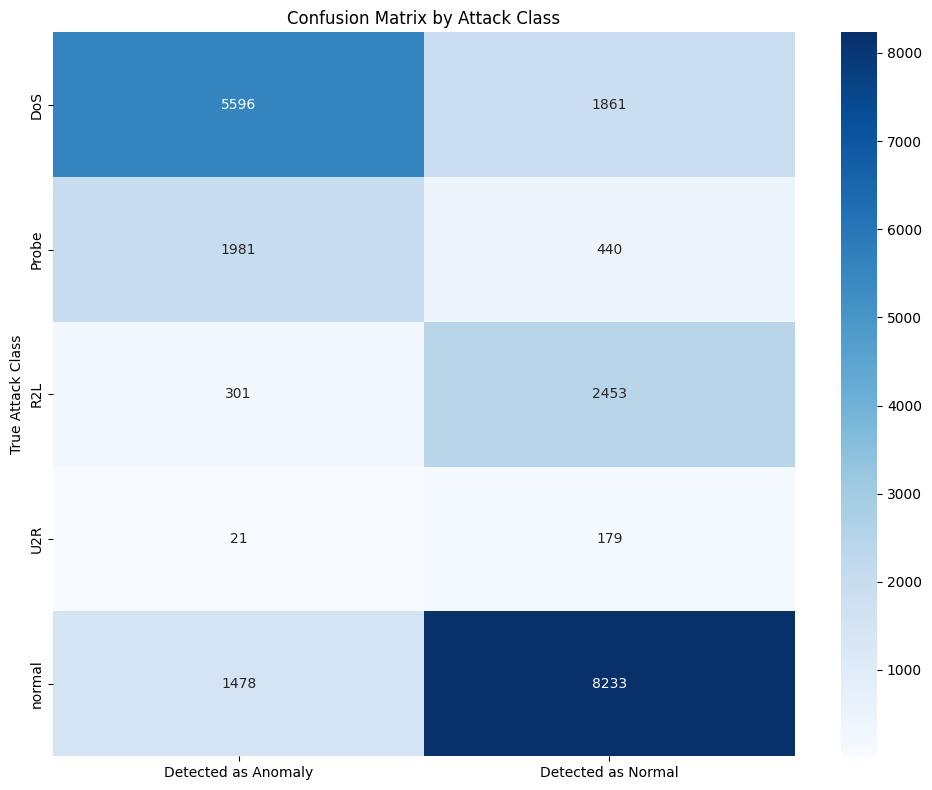

In [ ]:
def create_multiclass_cm(y_true_class, y_pred_binary):
    """
    Create a confusion matrix showing how each attack class was classified.

    For attack classes (DoS, Probe, R2L, U2R), correct detection is when y_pred = -1 (anomaly)
    For normal class, correct detection is when y_pred = 1 (normal)
    """
    classes = np.unique(y_true_class)
    cm = np.zeros((len(classes), 2))

    for i, cls in enumerate(classes):
        # Get predictions for this class
        cls_indices = y_true_class == cls
        preds = y_pred_binary[cls_indices]

        # Count correct and incorrect predictions
        if cls == "normal":
            cm[i, 0] = np.sum(preds == -1)  # incorrectly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # correctly detected as normal
        else:
            cm[i, 0] = np.sum(preds == -1)  # correctly detected as anomaly
            cm[i, 1] = np.sum(preds == 1)  # incorrectly detected as normal

    return cm, classes


# Create and plot the multi-class confusion matrix
cm_multi, classes = create_multiclass_cm(y_test_class, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_multi,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=["Detected as Anomaly", "Detected as Normal"],
    yticklabels=classes,
)
plt.ylabel("True Attack Class")
plt.title("Confusion Matrix by Attack Class")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate detection rates for each class
print("Detection rates by class:")
class_metrics = {}
for cls in np.unique(y_test_class):
    # Get indices for this class
    class_indices = y_test_class == cls

    # True values and predictions for this class
    y_true_cls = y_test[class_indices]
    y_pred_cls = y_pred[class_indices]

    # Calculate metrics
    if cls == "Normal":
        # For normal class, we want to detect 1 (normal)
        correct = np.sum((y_pred_cls == 1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=1, zero_division=0)
    else:
        # For attack classes, we want to detect -1 (anomaly)
        correct = np.sum((y_pred_cls == -1))
        precision = precision_score(
            y_true_cls, y_pred_cls, pos_label=-1, zero_division=0
        )
        recall = recall_score(y_true_cls, y_pred_cls, pos_label=-1, zero_division=0)

    total = len(y_pred_cls)
    detection_rate = correct / total
    f1 = f1_score(
        y_true_cls, y_pred_cls, pos_label=-1 if cls != "Normal" else 1, zero_division=0
    )

    class_metrics[cls] = {
        "detection_rate": detection_rate,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "count": total,
        "correctly_detected": correct,
    }

    print(f"{cls}: {detection_rate:.4f} ({correct}/{total})")

Detection rates by class:
DoS: 0.7504 (5596/7457)
Probe: 0.8183 (1981/2421)
R2L: 0.1093 (301/2754)
U2R: 0.1050 (21/200)
normal: 0.1522 (1478/9711)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use t-SNE to visualize the bottleneck features
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    test_features_2d[:, 0], test_features_2d[:, 1], c=y_test, cmap="viridis", alpha=0.6
)
plt.colorbar(scatter, label="Class")
plt.title("t-SNE Visualization of Bottleneck Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.savefig("tsne_visualization.png")
plt.close()

# Visualization of bottleneck features with OCSVM decision boundary
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    test_features_2d[:, 0],
    test_features_2d[:, 1],
    c=y_pred,
    cmap="coolwarm",
    alpha=0.6,
)
plt.colorbar(scatter, label="OCSVM Prediction")
plt.title("OCSVM Decision Boundary on t-SNE Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

KeyboardInterrupt: 